In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import LSTM, Dense
from sklearn.model_selection import train_test_split
import numpy as np

In [ ]:
data = pd.read_csv("/content/drive/MyDrive/energy timeseries/household_power_consumption.txt", sep=";")

/usr/local/lib/python3.8/dist-packages/IPython/core/interactiveshell.py:3326: DtypeWarning: Columns (2,3,4,5,6,7) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [ ]:
data.head()

,Date,Time,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
0,16/12/2006,17:24:00,4.216,0.418,234.840,18.400,0.000,1.000,17.0
1,16/12/2006,17:25:00,5.360,0.436,233.630,23.000,0.000,1.000,16.0
2,16/12/2006,17:26:00,5.374,0.498,233.290,23.000,0.000,2.000,17.0
3,16/12/2006,17:27:00,5.388,0.502,233.740,23.000,0.000,1.000,17.0
4,16/12/2006,17:28:00,3.666,0.528,235.680,15.800,0.000,1.000,17.0


In [ ]:
data.tail()

,Date,Time,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
2075254,26/11/2010,20:58:00,0.946,0.0,240.43,4.0,0.0,0.0,0.0
2075255,26/11/2010,20:59:00,0.944,0.0,240.0,4.0,0.0,0.0,0.0
2075256,26/11/2010,21:00:00,0.938,0.0,239.82,3.8,0.0,0.0,0.0
2075257,26/11/2010,21:01:00,0.934,0.0,239.7,3.8,0.0,0.0,0.0
2075258,26/11/2010,21:02:00,0.932,0.0,239.55,3.8,0.0,0.0,0.0


In [ ]:
data.shape

(2075259, 9)

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2075259 entries, 0 to 2075258
Data columns (total 9 columns):
 #   Column                 Dtype  
---  ------                 -----  
 0   Date                   object 
 1   Time                   object 
 2   Global_active_power    object 
 3   Global_reactive_power  object 
 4   Voltage                object 
 5   Global_intensity       object 
 6   Sub_metering_1         object 
 7   Sub_metering_2         object 
 8   Sub_metering_3         float64
dtypes: float64(1), object(8)
memory usage: 142.5+ MB


In [ ]:
data.describe()

,Sub_metering_3
count,2.049280e+06
mean,6.458447e+00
std,8.437154e+00
min,0.000000e+00
25%,0.000000e+00
50%,1.000000e+00
75%,1.700000e+01
max,3.100000e+01


In [ ]:
data['Sub_metering_1'].value_counts()

0.000    1840611
1.000      82920
0.0        39564
?          25979
2.000      18537
          ...   
72.0           1
81.0           1
76.0           1
63.0           1
57.0           1
Name: Sub_metering_1, Length: 153, dtype: int64

In [ ]:
data['Sub_metering_2'].value_counts()

0.000    1408274
1.000     367317
2.000     153938
0.0        28556
?          25979
          ...   
61.0           1
60.0           1
56.0           1
51.0           1
15.0           1
Name: Sub_metering_2, Length: 145, dtype: int64

In [ ]:
data.isnull().sum()

Date                         0
Time                         0
Global_active_power          0
Global_reactive_power        0
Voltage                      0
Global_intensity             0
Sub_metering_1               0
Sub_metering_2               0
Sub_metering_3           25979
dtype: int64

In [ ]:
data['Sub_metering_1'] = pd.to_numeric(data['Sub_metering_1'], errors='coerce')
data['Sub_metering_2'] = pd.to_numeric(data['Sub_metering_2'], errors='coerce')
data['Sub_metering_3'] = pd.to_numeric(data['Sub_metering_3'], errors='coerce')


In [ ]:
data.isnull().sum()

Date                         0
Time                         0
Global_active_power          0
Global_reactive_power        0
Voltage                      0
Global_intensity             0
Sub_metering_1           25979
Sub_metering_2           25979
Sub_metering_3           25979
dtype: int64

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2075259 entries, 0 to 2075258
Data columns (total 9 columns):
 #   Column                 Dtype  
---  ------                 -----  
 0   Date                   object 
 1   Time                   object 
 2   Global_active_power    object 
 3   Global_reactive_power  object 
 4   Voltage                object 
 5   Global_intensity       object 
 6   Sub_metering_1         float64
 7   Sub_metering_2         float64
 8   Sub_metering_3         float64
dtypes: float64(3), object(6)
memory usage: 142.5+ MB


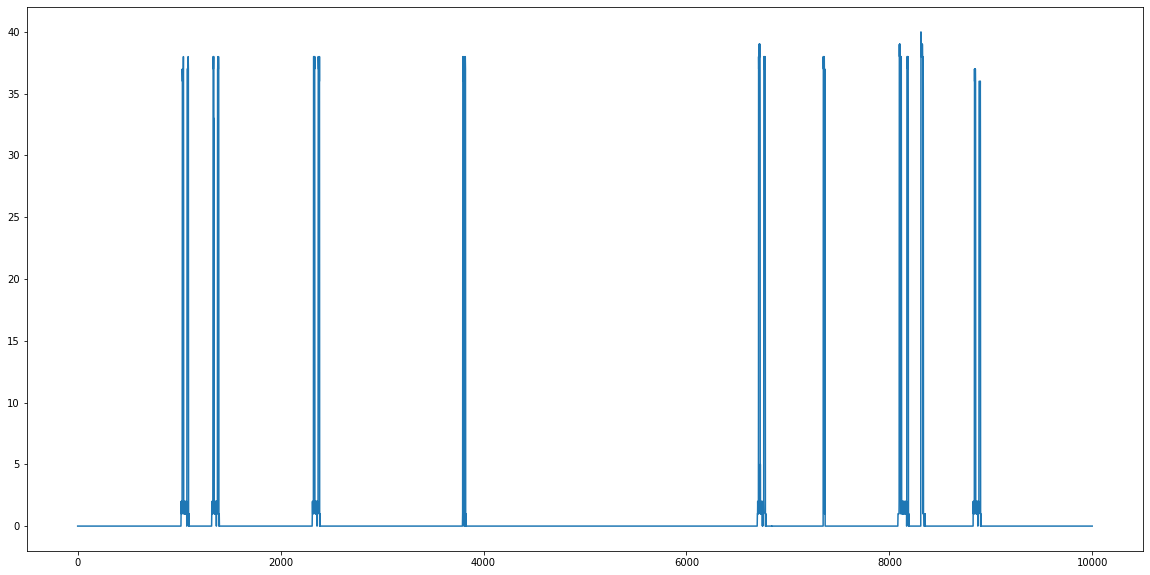

In [ ]:
plt.figure(figsize=(20,10))
plt.plot(data.Sub_metering_1[:10000])

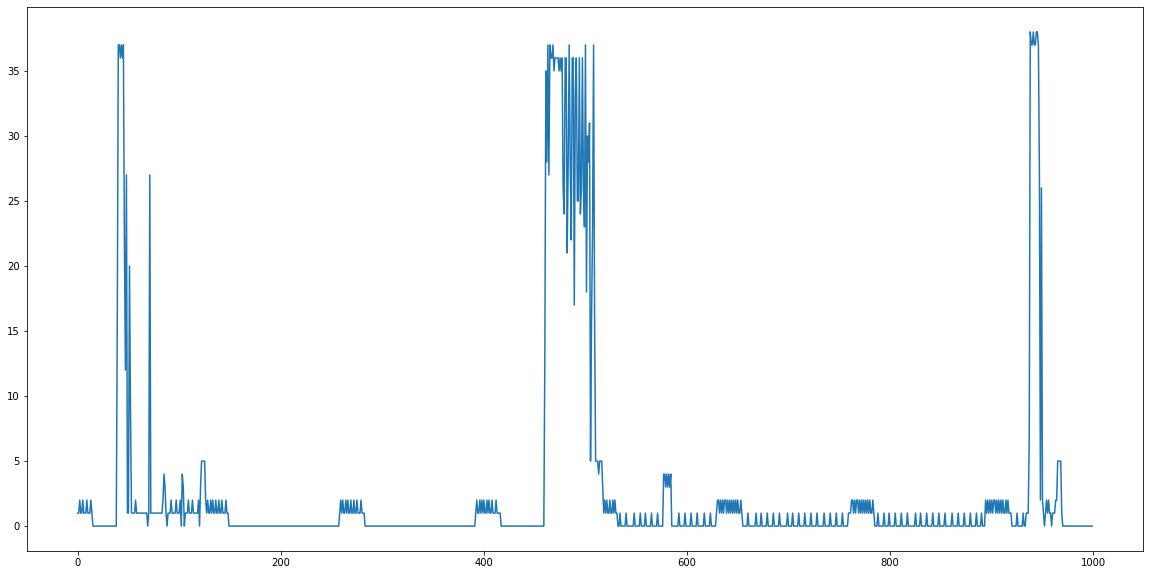

In [ ]:
plt.figure(figsize=(20,10))
plt.plot(data.Sub_metering_2[:1000])

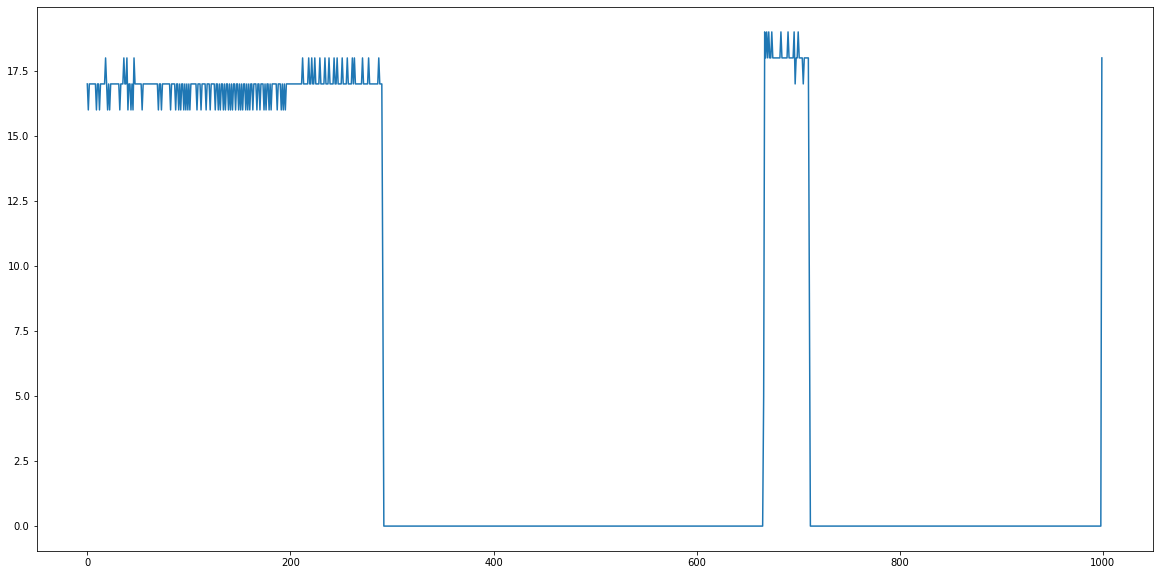

In [ ]:
plt.figure(figsize=(20,10))
plt.plot(data.Sub_metering_3[:1000])

In [ ]:
# Create a function to process the data into a format that can be used by the LSTM
def process_data(data, look_back=1):
    X, y = [], []
    for i in range(len(data)-look_back-1):
        X.append(data.iloc[i:(i+look_back)].values)
        y.append(data.iloc[i + look_back])
    return np.array(X), np.array(y)

In [ ]:
def clean_data(df):
    # Replace non-float and non-int values with NaN
    for col in ['Sub_metering_1','Sub_metering_2','Sub_metering_3']:
        if df[col].dtype != 'float64' and df[col].dtype != 'int64':
            df[col] = df[col].replace(df[col].dropna().unique(), np.nan)
    # Perform forward filling on the NaN values
    df.fillna(method='ffill', inplace=True)
    return df

In [ ]:
# Create a function to create and train the LSTM model
def create_and_train_model(X_train, y_train, X_test, y_test):
    # Reshape the input data for the LSTM
    X_train = np.reshape(X_train, (X_train.shape[0], 1, X_train.shape[1]))
    X_test = np.reshape(X_test, (X_test.shape[0], 1, X_test.shape[1]))

    # Create the LSTM model
    model = Sequential()
    model.add(LSTM(10, input_shape=(1, look_back)))
    model.add(Dense(1))
    model.compile(loss='mean_squared_error', optimizer='adam')

    # Train the model
    history = model.fit(X_train, y_train, epochs=10, batch_size=16, validation_data=(X_test, y_test), verbose=2)

    # Plot training and validation loss
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Test'], loc='upper right')
    plt.show()
    
    return model


In [ ]:
# Process the data for data1
look_back = 100
cleaned_data = clean_data(data)
X, y = process_data(cleaned_data['Sub_metering_1'], look_back)

Epoch 1/10
90789/90789 - 336s - loss: 8.1311 - val_loss: 6.8461 - 336s/epoch - 4ms/step
Epoch 2/10
90789/90789 - 315s - loss: 5.5330 - val_loss: 5.0388 - 315s/epoch - 3ms/step
Epoch 3/10
90789/90789 - 330s - loss: 5.2453 - val_loss: 4.9319 - 330s/epoch - 4ms/step
Epoch 4/10
90789/90789 - 332s - loss: 4.9890 - val_loss: 4.8616 - 332s/epoch - 4ms/step
Epoch 5/10
90789/90789 - 331s - loss: 4.8812 - val_loss: 4.7534 - 331s/epoch - 4ms/step
Epoch 6/10
90789/90789 - 313s - loss: 4.7757 - val_loss: 4.6873 - 313s/epoch - 3ms/step
Epoch 7/10
90789/90789 - 330s - loss: 4.7469 - val_loss: 4.7127 - 330s/epoch - 4ms/step
Epoch 8/10
90789/90789 - 331s - loss: 4.6950 - val_loss: 4.5576 - 331s/epoch - 4ms/step
Epoch 9/10
90789/90789 - 331s - loss: 4.6454 - val_loss: 4.8275 - 331s/epoch - 4ms/step
Epoch 10/10
90789/90789 - 331s - loss: 4.5276 - val_loss: 4.6340 - 331s/epoch - 4ms/step


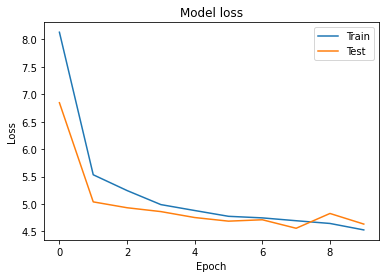

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, shuffle=False)
model1 = create_and_train_model(X_train, y_train, X_test, y_test)

In [ ]:
look_back = 100
cleaned_data = clean_data(data)
X, y = process_data(cleaned_data['Sub_metering_2'], look_back)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, shuffle=False)
model1 = create_and_train_model(X_train, y_train, X_test, y_test)

Epoch 1/10
90789/90789 - 325s - loss: 8.2603 - val_loss: 4.7153 - 325s/epoch - 4ms/step
Epoch 2/10
90789/90789 - 323s - loss: 6.0902 - val_loss: 5.2675 - 323s/epoch - 4ms/step
Epoch 3/10
90789/90789 - 338s - loss: 5.9754 - val_loss: 4.4705 - 338s/epoch - 4ms/step
Epoch 4/10
90789/90789 - 337s - loss: 5.5115 - val_loss: 4.0882 - 337s/epoch - 4ms/step
Epoch 5/10
90789/90789 - 336s - loss: 5.5527 - val_loss: 4.1805 - 336s/epoch - 4ms/step
Epoch 6/10
90789/90789 - 338s - loss: 5.3701 - val_loss: 4.2008 - 338s/epoch - 4ms/step
Epoch 7/10
90789/90789 - 336s - loss: 5.2170 - val_loss: 3.8381 - 336s/epoch - 4ms/step
Epoch 8/10
90789/90789 - 336s - loss: 5.1543 - val_loss: 3.7517 - 336s/epoch - 4ms/step
Epoch 9/10
90789/90789 - 341s - loss: 5.1633 - val_loss: 3.7638 - 341s/epoch - 4ms/step
Epoch 10/10


In [ ]:
look_back = 100
cleaned_data = clean_data(data)
X, y = process_data(cleaned_data['Sub_metering_3'], look_back)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, shuffle=False)
model1 = create_and_train_model(X_train, y_train, X_test, y_test)